$ECD_{q=1}$ and other optimizers on the Sombrero potential with a rotational symmetry: taking the chaos parameter $\nu$  nonzero introduces angular momentum, illlustrating the issue with ECD's conservation laws.  

The example here is exaggerated to illustrate the issue that can arise in more complex loss landscapes such as that arising in transformer training; in fact ECD converges to the minimum manifold in this simple case if we simply turn off $\nu$.    

We stress that the HP priors developed in https://arxiv.org/pdf/2501.18419 and references therein are in the high-dimension regime, different from this toy potential.

The comparison with Adam, SGDM and Soap/Shampoo is also interesting here, exhibiting their different behaviors with respect to the rotational direction.

This code was developed in collaboration with Claude max.

Initial position: (0.2, 0.5)
Initial radius: 0.539 (manifold is at r=1)
Running 15000 steps...



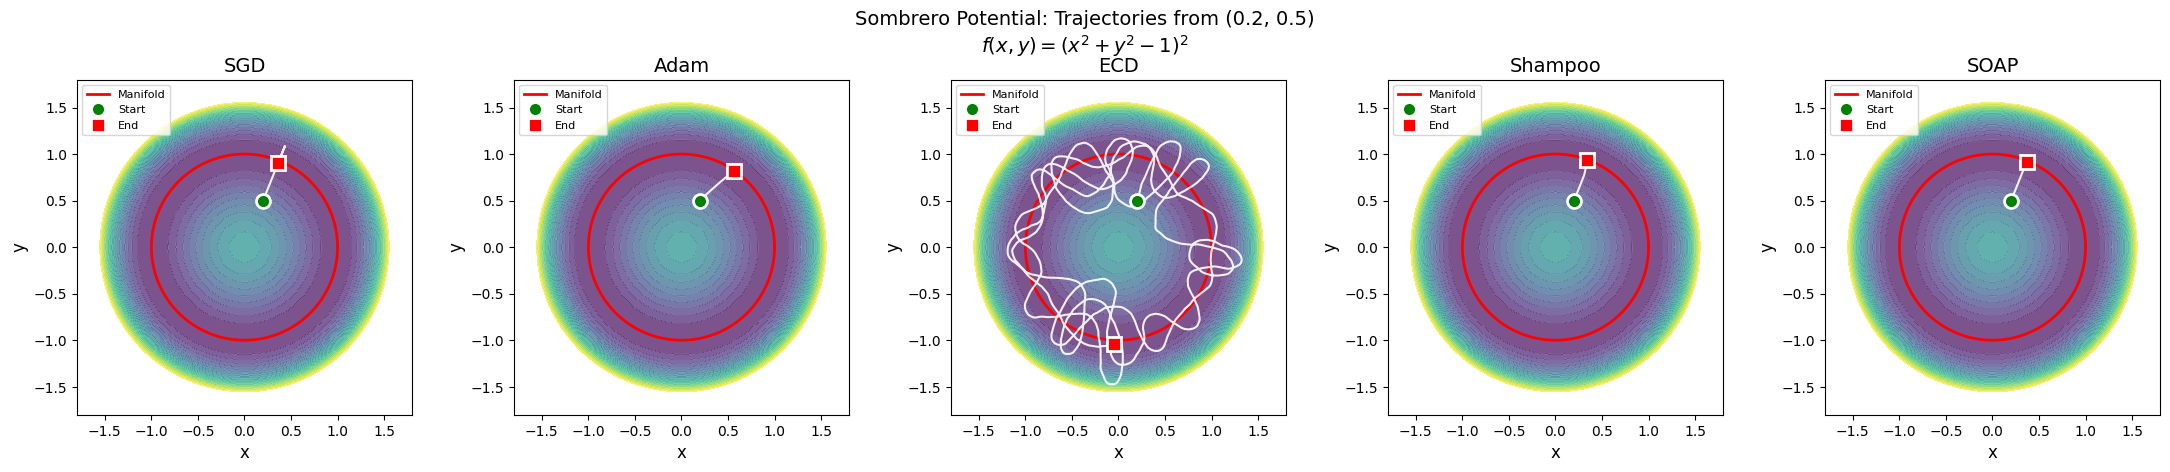

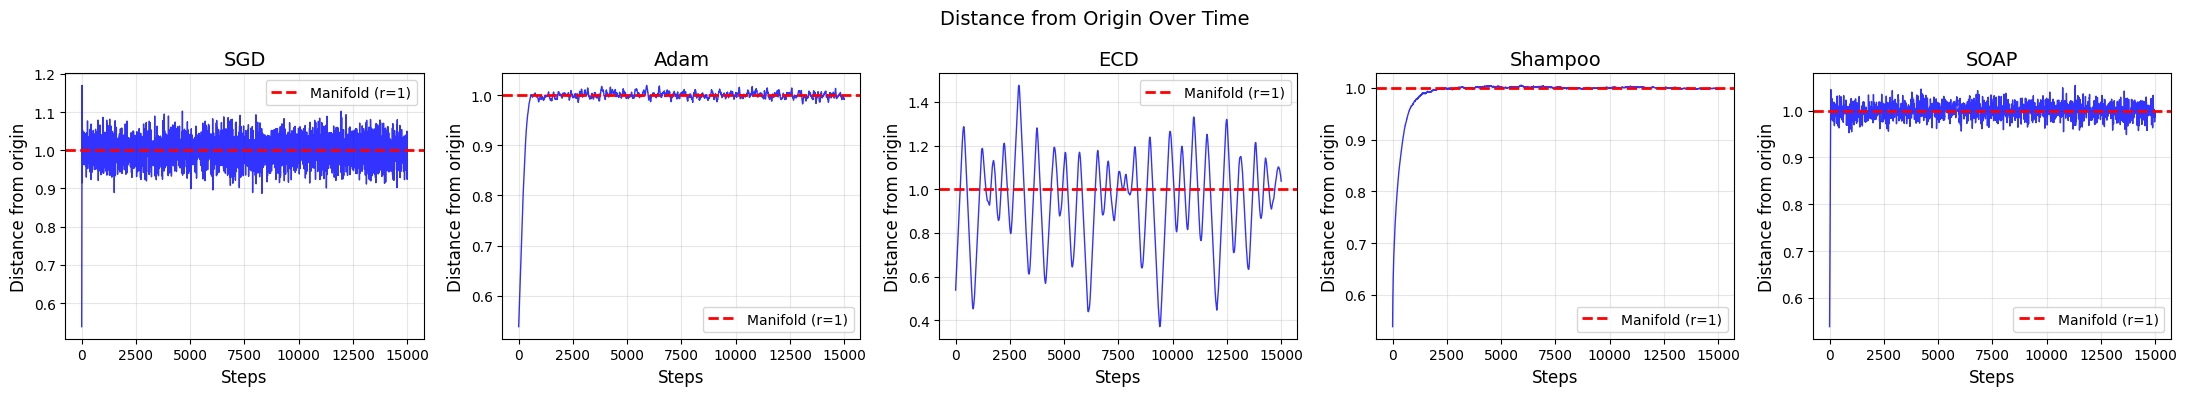

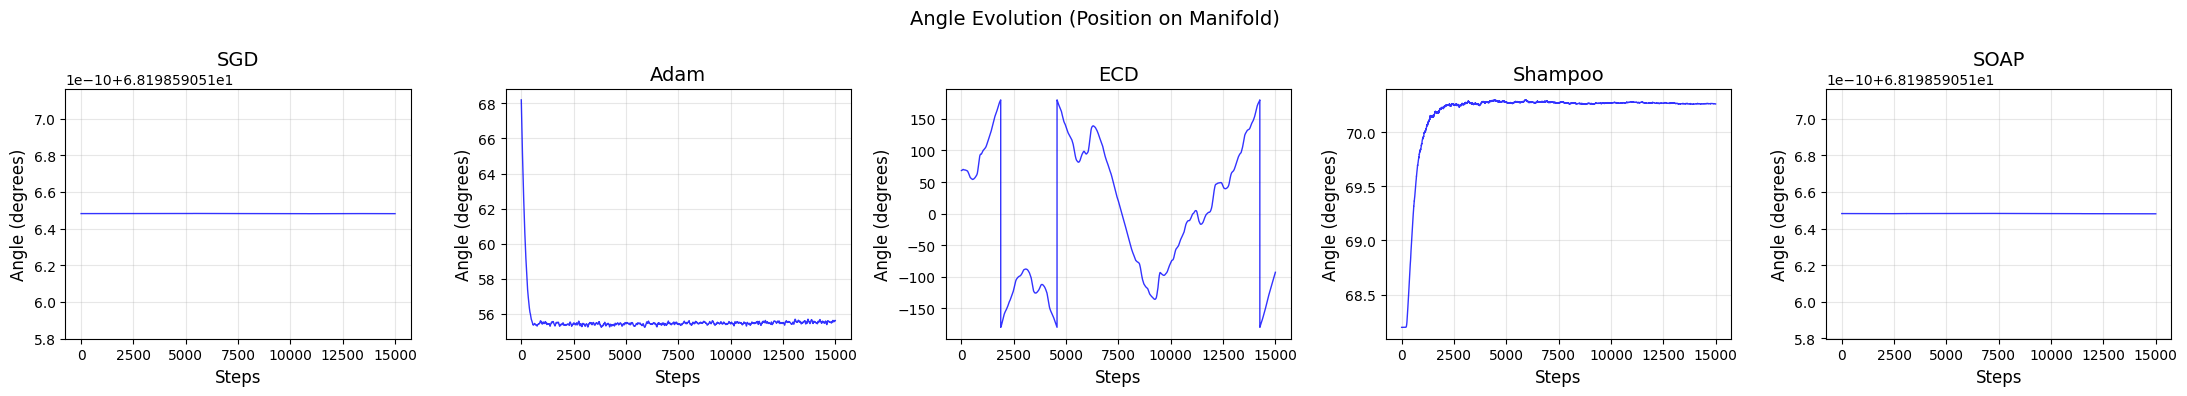

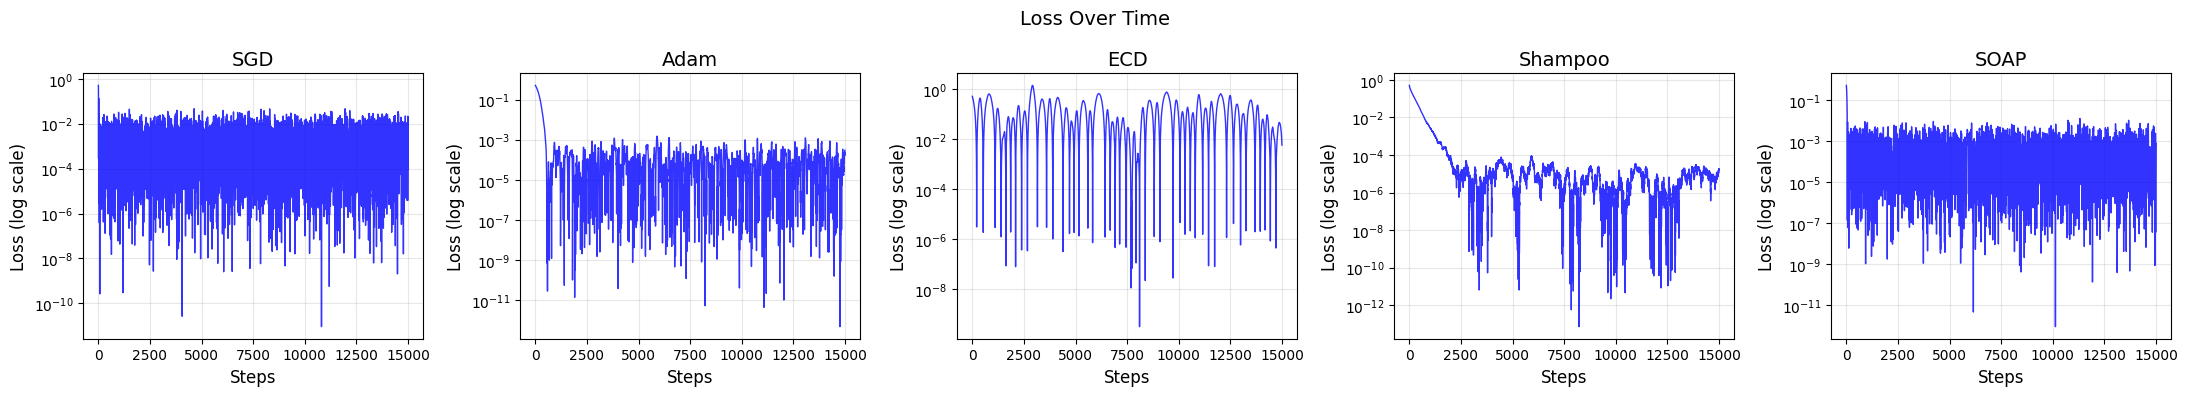

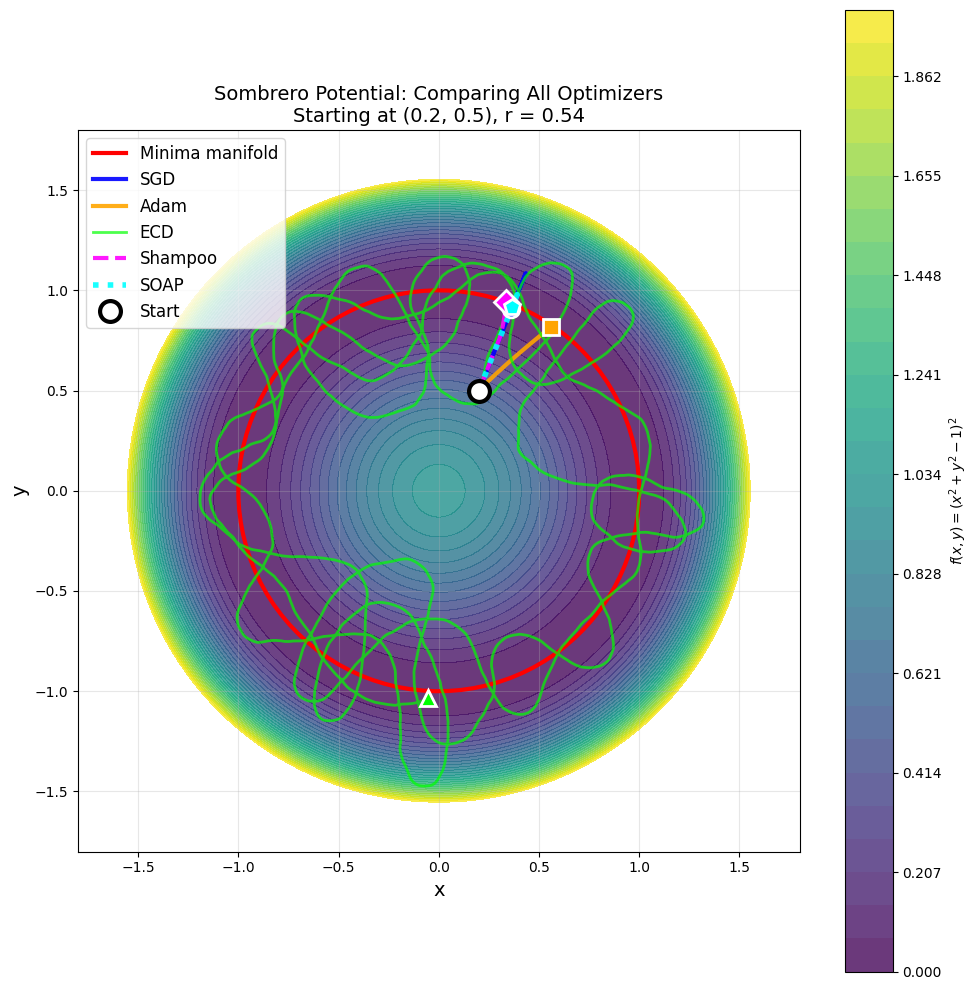

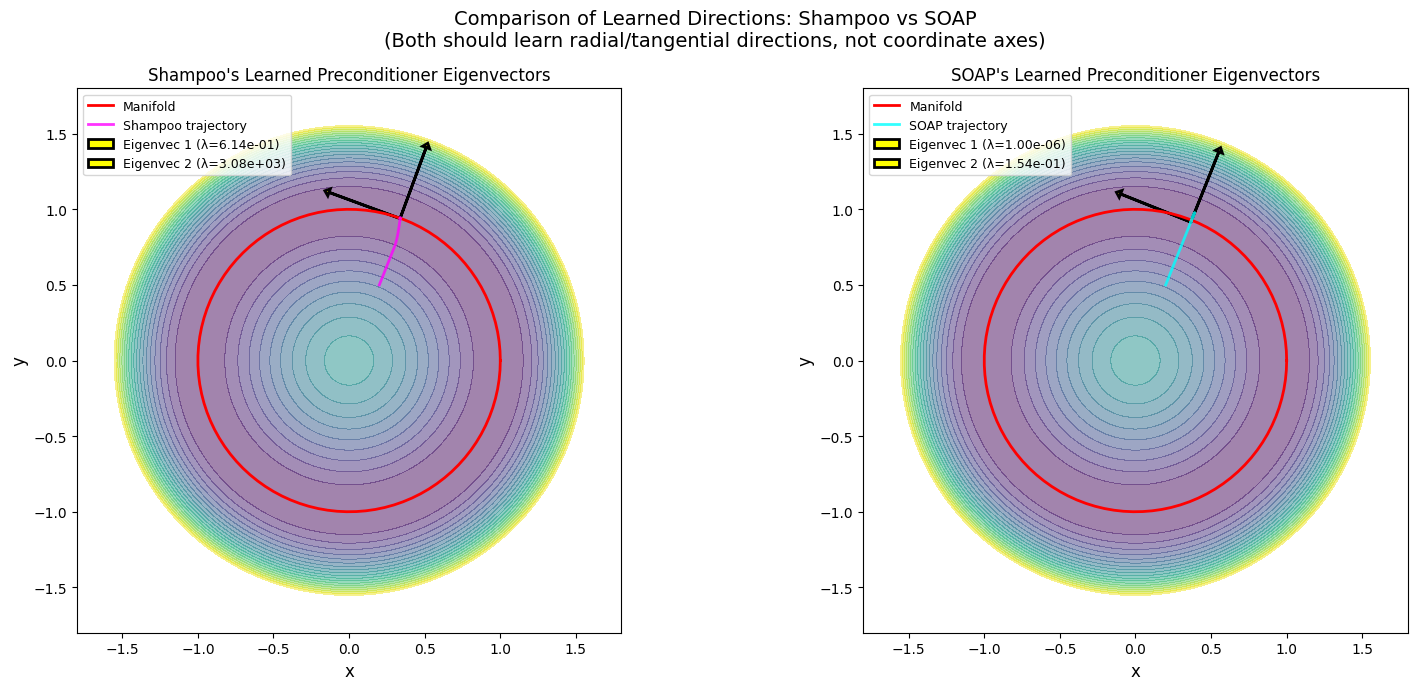

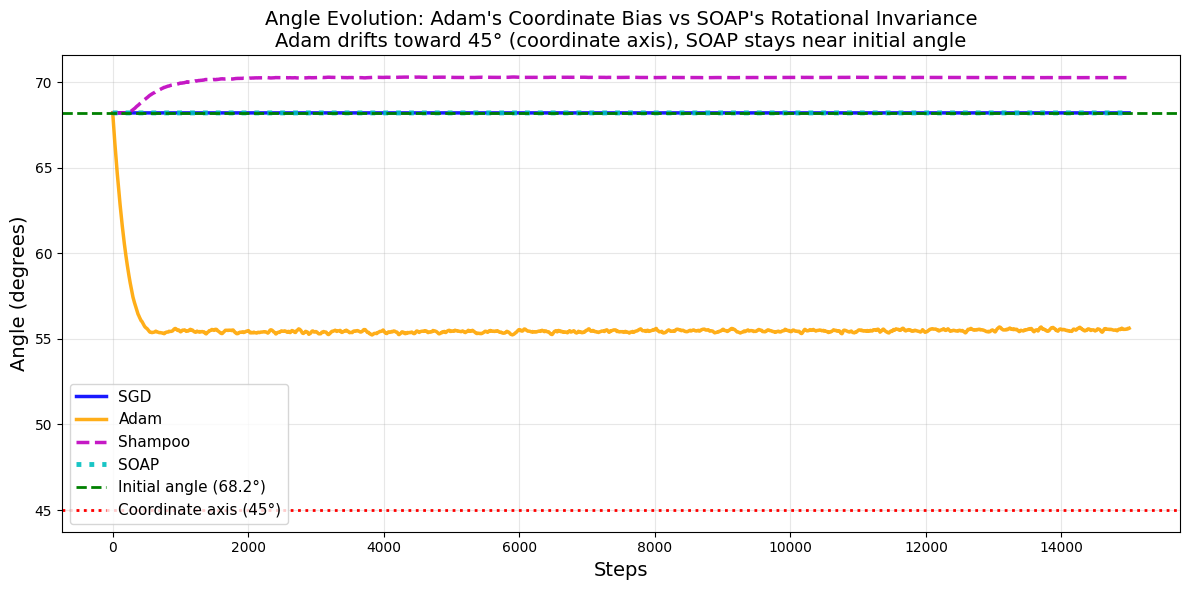


SHAMPOO Preconditioner L (accumulated):
[[ 368.09459381  998.61835894]
 [ 998.61835894 2714.32836567]]

Eigenvalues: [6.13591979e-01 3.08180937e+03]
Eigenvectors:
[[-0.93847445  0.34534868]
 [ 0.34534868  0.93847445]]

------------------------------------------------------------
SOAP Preconditioner L (bias-corrected):
[[0.02117967 0.05294917]
 [0.05294917 0.13237293]]

Eigenvalues: [1.00000000e-06 1.53553594e-01]
Eigenvectors:
[[-0.92847669  0.37139068]
 [ 0.37139068  0.92847669]]

Final positions:
  SGD     : (  0.3618,   0.9045), r = 0.9742, angle = 68.2°
  Adam    : (  0.5598,   0.8182), r = 0.9914, angle = 55.6°
  ECD     : ( -0.0520,  -1.0358), r = 1.0371, angle = -92.9°
  Shampoo : (  0.3371,   0.9393), r = 0.9979, angle = 70.3°
  SOAP    : (  0.3663,   0.9157), r = 0.9863, angle = 68.2°

SUMMARY: Key differences between optimizers

SGD:      - Uses momentum but no adaptive learning rates
          - Converges radially to manifold, preserves initial angle
          - No coordina

In [8]:
# === ECD_q1, Adam, SGD, Shampoo, and SOAP on Sombrero Potential ===
# f(x,y) = (x² + y² - 1)²
# Minima manifold: the unit circle (x² + y² = 1)

import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# HYPERPARAMETERS - ADJUST THESE
# =============================================================================

# Initialization (OFF the minima manifold, ASYMMETRIC to break 45° symmetry)
x0 = 0.2          # Initial x coordinate
y0 = 0.5          # Initial y coordinate (different from x0!)

# Training settings
steps = 15000     # More steps to see dynamics
sigma = 0.1       # Label noise to induce manifold exploration
seed = 42         # Random seed

# SGD hyperparameters
lr_sgd = 1e-2
momentum_sgd = 0.9

# Adam hyperparameters
lr_adam = 1e-3
beta1_adam = 0.9
beta2_adam = 0.999

# ECD hyperparameters
# NOTE: With label noise (sigma > 0), the stochastic gradients help with exploration,
# so we can reduce or eliminate bounce noise.
lr_ecd = 0.005     # Scaled learning rate Δt̂
eta_ecd = 5.0     # Concentration parameter (higher = tighter)
F0_ecd = -1.0     # Loss offset
nu_ecd = 0.05      # No bounce noise needed when we have label noise

# Shampoo hyperparameters
lr_shampoo = 1e-2
epsilon_shampoo = 1e-6  # Regularization for matrix inverse

# SOAP hyperparameters
# Using smaller beta2 to make EMA more responsive (see preconditioner adapt faster)
lr_soap = 1e-2
beta1_soap = 0.9       # Momentum for gradient (like Adam)
beta2_soap = 0.9       # SMALLER than usual! Makes preconditioner adapt faster
epsilon_soap = 1e-6    # Regularization for matrix inverse

# =============================================================================
# LOSS FUNCTION AND GRADIENT
# =============================================================================

def sombrero_loss(x, y, sigma=0.0):
    """Sombrero potential: f(x,y) = (x² + y² - 1 + z)²"""
    z = sigma * np.random.randn() if sigma > 0 else 0.0
    return (x**2 + y**2 - 1 + z)**2

def sombrero_gradient(x, y, sigma=0.0):
    """Gradient of sombrero potential"""
    z = sigma * np.random.randn() if sigma > 0 else 0.0
    r2 = x**2 + y**2
    factor = 4 * (r2 - 1 + z)
    return np.array([factor * x, factor * y])

# =============================================================================
# OPTIMIZERS
# =============================================================================

def sgd_step(theta, grad, velocity, lr, momentum):
    """SGD with momentum"""
    velocity = momentum * velocity + grad
    theta = theta - lr * velocity
    return theta, velocity

def adam_step(theta, grad, m, v, t, lr, beta1=0.9, beta2=0.999, eps=1e-8):
    """Adam update"""
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * grad**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    theta = theta - lr * m_hat / (np.sqrt(v_hat) + eps)
    return theta, m, v

class ECDq1:
    """Energy Conserving Descent (q=1) optimizer"""

    def __init__(self, dim, lr_scaled, eta, F0, nu_scaled, seed=None):
        self.dim = dim
        self.eta = eta
        self.F0 = F0
        self.lr = lr_scaled / np.sqrt(eta)
        self.nu = nu_scaled / np.sqrt(dim) if dim > 0 else 0
        self.u = None
        self.p2 = 1.0
        if seed is not None:
            np.random.seed(seed)

    def initialize(self, grad):
        self.u = -grad.copy()
        norm = np.linalg.norm(self.u)
        if norm > 1e-30:
            self.u /= norm
        self.p2 = 1.0

    def step(self, theta, loss, grad):
        if self.u is None:
            self.initialize(grad)

        d = self.dim
        energy = loss - self.F0

        if energy < 1e-40:
            return theta

        if abs(1.0 - self.p2) > 1e-10 and self.p2 > 0:
            self.u *= np.sqrt(1.0 / self.p2)

        prefactor = -0.5 * self.lr * self.eta * d / max(d - 1, 1)
        u_dot_grad = np.dot(self.u, grad)
        du = (prefactor / energy) * (grad - self.u * u_dot_grad)
        self.u = self.u + du

        self.p2 = np.dot(self.u, self.u)
        pnorm = np.sqrt(self.p2)

        theta_new = theta + self.lr * self.u

        if self.nu > 0:
            z = np.random.randn(d)
            u_new = self.u / pnorm + self.nu * z
            p2_new = np.dot(u_new, u_new)
            self.u = pnorm * u_new / np.sqrt(p2_new)

        self.p2 = pnorm**2
        return theta_new


class Shampoo:
    """
    Shampoo optimizer for vector parameters (treating θ as a dim×1 matrix).

    Shampoo maintains preconditioners based on gradient correlations:
    - L (dim×dim): accumulates G @ G.T (outer product)
    - R (1×1): accumulates G.T @ G (scalar, inner product)

    Update: θ ← θ - lr * L^{-1/4} @ G / R^{1/4}

    Key difference from Adam:
    - Adam: diagonal scaling (g_x² and g_y² separately)
    - Shampoo: full preconditioner that captures correlations

    This means Shampoo learns directions intrinsic to the loss landscape
    (e.g., radial vs tangential on the sombrero), rather than being tied
    to the coordinate axes.
    """

    def __init__(self, dim, lr, epsilon=1e-6):
        self.dim = dim
        self.lr = lr
        self.epsilon = epsilon

        # Left preconditioner: L (dim × dim), accumulates G @ G.T
        self.L = np.zeros((dim, dim))

        # Right preconditioner: R (1 × 1 = scalar), accumulates G.T @ G
        self.R = 0.0

        self.t = 0

    def matrix_power_neg_quarter(self, M):
        """
        Compute M^{-1/4} for a symmetric positive semi-definite matrix.
        Uses eigendecomposition: M = V D V.T => M^{-1/4} = V D^{-1/4} V.T
        """
        M_reg = M + self.epsilon * np.eye(M.shape[0])
        eigenvalues, eigenvectors = np.linalg.eigh(M_reg)
        eigenvalues = np.maximum(eigenvalues, self.epsilon)
        D_neg_quarter = np.diag(eigenvalues ** (-0.25))
        return eigenvectors @ D_neg_quarter @ eigenvectors.T

    def step(self, theta, grad):
        self.t += 1
        G = grad.reshape(-1, 1)  # (dim, 1)

        # Accumulate preconditioners (simple sum, no EMA)
        self.L += G @ G.T
        self.R += (G.T @ G).item()

        # Compute preconditioned gradient
        L_neg_quarter = self.matrix_power_neg_quarter(self.L)
        R_neg_quarter = (self.R + self.epsilon) ** (-0.25)
        preconditioned_grad = (L_neg_quarter @ G * R_neg_quarter).flatten()

        theta_new = theta - self.lr * preconditioned_grad
        return theta_new

    def get_preconditioner_eigenvectors(self):
        """Return the eigenvectors of L for visualization."""
        if np.allclose(self.L, 0):
            return None, None
        L_reg = self.L + self.epsilon * np.eye(self.dim)
        eigenvalues, eigenvectors = np.linalg.eigh(L_reg)
        return eigenvalues, eigenvectors


class SOAP:
    """
    SOAP: Shampoo + Adam in the Preconditioner (Vyas et al., 2024)

    Key differences from Shampoo:
    1. Uses exponential moving average (EMA) for preconditioners L and R,
       similar to Adam's second moment estimate
    2. Maintains first moment (momentum) for the gradient, like Adam
    3. Uses bias correction for both moments

    This combines Shampoo's ability to learn landscape-intrinsic directions
    with Adam's adaptive learning and momentum.

    For a dim-dimensional parameter vector treated as a (dim × 1) matrix:
    - L (dim × dim): EMA of G @ G.T
    - R (scalar): EMA of G.T @ G
    - m (dim,): EMA of gradient (momentum)

    Update rule:
        m ← β₁ m + (1 - β₁) g           # Gradient momentum
        L ← β₂ L + (1 - β₂) G @ G.T     # Preconditioner EMA
        R ← β₂ R + (1 - β₂) G.T @ G     # Preconditioner EMA

        m̂ = m / (1 - β₁ᵗ)               # Bias correction
        L̂ = L / (1 - β₂ᵗ)               # Bias correction
        R̂ = R / (1 - β₂ᵗ)               # Bias correction

        θ ← θ - lr * L̂^{-1/4} @ m̂ / R̂^{1/4}
    """

    def __init__(self, dim, lr, beta1=0.9, beta2=0.999, epsilon=1e-6):
        self.dim = dim
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # First moment (gradient momentum)
        self.m = np.zeros(dim)

        # Second moment for preconditioners (EMA, like Adam)
        self.L = np.zeros((dim, dim))  # Left preconditioner
        self.R = 0.0                    # Right preconditioner (scalar)

        self.t = 0

    def matrix_power_neg_quarter(self, M):
        """
        Compute M^{-1/4} for a symmetric positive semi-definite matrix.
        Uses eigendecomposition: M = V D V.T => M^{-1/4} = V D^{-1/4} V.T
        """
        M_reg = M + self.epsilon * np.eye(M.shape[0])
        eigenvalues, eigenvectors = np.linalg.eigh(M_reg)
        eigenvalues = np.maximum(eigenvalues, self.epsilon)
        D_neg_quarter = np.diag(eigenvalues ** (-0.25))
        return eigenvectors @ D_neg_quarter @ eigenvectors.T

    def step(self, theta, grad):
        """
        Perform one SOAP update step.

        Args:
            theta: current parameters (dim,)
            grad: current gradient (dim,)

        Returns:
            theta_new: updated parameters
        """
        self.t += 1
        G = grad.reshape(-1, 1)  # (dim, 1)

        # Update first moment (gradient momentum, like Adam)
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad

        # Update second moments for preconditioners (EMA, like Adam)
        self.L = self.beta2 * self.L + (1 - self.beta2) * (G @ G.T)
        self.R = self.beta2 * self.R + (1 - self.beta2) * (G.T @ G).item()

        # Bias correction
        m_hat = self.m / (1 - self.beta1 ** self.t)
        L_hat = self.L / (1 - self.beta2 ** self.t)
        R_hat = self.R / (1 - self.beta2 ** self.t)

        # Compute preconditioned update direction
        L_neg_quarter = self.matrix_power_neg_quarter(L_hat)
        R_neg_quarter = (R_hat + self.epsilon) ** (-0.25)

        # Apply preconditioner to the momentum (not raw gradient)
        M_hat = m_hat.reshape(-1, 1)
        preconditioned_update = (L_neg_quarter @ M_hat * R_neg_quarter).flatten()

        theta_new = theta - self.lr * preconditioned_update
        return theta_new

    def get_preconditioner_eigenvectors(self):
        """Return the eigenvectors of L for visualization."""
        if np.allclose(self.L, 0):
            return None, None
        # Use bias-corrected L for visualization
        L_hat = self.L / (1 - self.beta2 ** max(self.t, 1))
        L_reg = L_hat + self.epsilon * np.eye(self.dim)
        eigenvalues, eigenvectors = np.linalg.eigh(L_reg)
        return eigenvalues, eigenvectors


# =============================================================================
# TRAINING LOOPS
# =============================================================================

def train_sgd(x0, y0, sigma, steps, lr, momentum, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta = np.array([x0, y0])
    velocity = np.zeros(2)
    trajectory = [theta.copy()]
    for _ in range(steps):
        grad = sombrero_gradient(theta[0], theta[1], sigma)
        theta, velocity = sgd_step(theta, grad, velocity, lr, momentum)
        trajectory.append(theta.copy())
    return np.array(trajectory)

def train_adam(x0, y0, sigma, steps, lr, beta1=0.9, beta2=0.999, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta = np.array([x0, y0])
    m, v = np.zeros(2), np.zeros(2)
    trajectory = [theta.copy()]
    for t in range(1, steps + 1):
        grad = sombrero_gradient(theta[0], theta[1], sigma)
        theta, m, v = adam_step(theta, grad, m, v, t, lr, beta1, beta2)
        trajectory.append(theta.copy())
    return np.array(trajectory)

def train_ecd(x0, y0, sigma, steps, lr_scaled, eta, F0, nu_scaled, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta = np.array([x0, y0])
    optimizer = ECDq1(dim=2, lr_scaled=lr_scaled, eta=eta, F0=F0, nu_scaled=nu_scaled, seed=seed)
    trajectory = [theta.copy()]
    for _ in range(steps):
        loss = sombrero_loss(theta[0], theta[1], sigma)
        grad = sombrero_gradient(theta[0], theta[1], sigma)
        theta = optimizer.step(theta, loss, grad)
        trajectory.append(theta.copy())
    return np.array(trajectory), optimizer

def train_shampoo(x0, y0, sigma, steps, lr, epsilon=1e-6, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta = np.array([x0, y0])
    optimizer = Shampoo(dim=2, lr=lr, epsilon=epsilon)
    trajectory = [theta.copy()]
    for _ in range(steps):
        grad = sombrero_gradient(theta[0], theta[1], sigma)
        theta = optimizer.step(theta, grad)
        trajectory.append(theta.copy())
    return np.array(trajectory), optimizer

def train_soap(x0, y0, sigma, steps, lr, beta1=0.9, beta2=0.999, epsilon=1e-6, seed=None):
    if seed is not None:
        np.random.seed(seed)
    theta = np.array([x0, y0])
    optimizer = SOAP(dim=2, lr=lr, beta1=beta1, beta2=beta2, epsilon=epsilon)
    trajectory = [theta.copy()]
    for _ in range(steps):
        grad = sombrero_gradient(theta[0], theta[1], sigma)
        theta = optimizer.step(theta, grad)
        trajectory.append(theta.copy())
    return np.array(trajectory), optimizer

# =============================================================================
# RUN EXPERIMENT
# =============================================================================

print(f"Initial position: ({x0}, {y0})")
print(f"Initial radius: {np.sqrt(x0**2 + y0**2):.3f} (manifold is at r=1)")
print(f"Running {steps} steps...")
print()

# Train all optimizers
traj_sgd = train_sgd(x0, y0, sigma, steps, lr_sgd, momentum_sgd, seed=seed)
traj_adam = train_adam(x0, y0, sigma, steps, lr_adam, beta1_adam, beta2_adam, seed=seed)
traj_ecd, ecd_opt = train_ecd(x0, y0, sigma, steps, lr_ecd, eta_ecd, F0_ecd, nu_ecd, seed=seed)
traj_shampoo, shampoo_opt = train_shampoo(x0, y0, sigma, steps, lr_shampoo, epsilon_shampoo, seed=seed)
traj_soap, soap_opt = train_soap(x0, y0, sigma, steps, lr_soap, beta1_soap, beta2_soap, epsilon_soap, seed=seed)

trajectories = {
    "SGD": traj_sgd,
    "Adam": traj_adam,
    "ECD": traj_ecd,
    "Shampoo": traj_shampoo,
    "SOAP": traj_soap
}

# =============================================================================
# PLOTTING
# =============================================================================

# Create grid for contour plots
x_grid = np.linspace(-1.8, 1.8, 200)
y_grid = np.linspace(-1.8, 1.8, 200)
X, Y = np.meshgrid(x_grid, y_grid)
Z = (X**2 + Y**2 - 1)**2
theta_circle = np.linspace(0, 2*np.pi, 100)

# --- Figure 1: Trajectories in (x, y) space ---
fig, axes = plt.subplots(1, 5, figsize=(22, 4.5))

for idx, (name, traj) in enumerate(trajectories.items()):
    ax = axes[idx]
    levels = np.linspace(0, 2, 20)
    ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.7)
    ax.contour(X, Y, Z, levels=levels, colors='white', alpha=0.3, linewidths=0.5)
    ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'r-', linewidth=2, label='Manifold')
    ax.plot(traj[:, 0], traj[:, 1], 'w-', linewidth=1.5, alpha=0.9)
    ax.plot(traj[0, 0], traj[0, 1], 'go', markersize=10, markeredgecolor='white',
            markeredgewidth=2, label='Start', zorder=10)
    ax.plot(traj[-1, 0], traj[-1, 1], 'rs', markersize=10, markeredgecolor='white',
            markeredgewidth=2, label='End', zorder=10)
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.8, 1.8)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_title(f"{name}", fontsize=14)
    ax.set_aspect('equal')
    ax.legend(loc='upper left', fontsize=8)

plt.suptitle(f"Sombrero Potential: Trajectories from ({x0}, {y0})\n" +
             r"$f(x,y) = (x^2+y^2-1)^2$", fontsize=14)
plt.tight_layout()
plt.show()

# --- Figure 2: Distance from origin over time ---
fig, axes = plt.subplots(1, 5, figsize=(22, 4))

for idx, (name, traj) in enumerate(trajectories.items()):
    ax = axes[idx]
    dist = np.sqrt(traj[:, 0]**2 + traj[:, 1]**2)
    ax.plot(dist, 'b-', linewidth=1, alpha=0.8)
    ax.axhline(y=1.0, color='r', linestyle='--', linewidth=2, label='Manifold (r=1)')
    ax.set_xlabel("Steps", fontsize=12)
    ax.set_ylabel("Distance from origin", fontsize=12)
    ax.set_title(f"{name}", fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Distance from Origin Over Time", fontsize=14)
plt.tight_layout()
plt.show()

# --- Figure 3: Angle evolution ---
fig, axes = plt.subplots(1, 5, figsize=(22, 4))

for idx, (name, traj) in enumerate(trajectories.items()):
    ax = axes[idx]
    angles = np.rad2deg(np.arctan2(traj[:, 1], traj[:, 0]))
    ax.plot(angles, 'b-', linewidth=1, alpha=0.8)
    ax.set_xlabel("Steps", fontsize=12)
    ax.set_ylabel("Angle (degrees)", fontsize=12)
    ax.set_title(f"{name}", fontsize=14)
    ax.grid(True, alpha=0.3)

plt.suptitle("Angle Evolution (Position on Manifold)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Figure 4: Loss over time ---
fig, axes = plt.subplots(1, 5, figsize=(22, 4))

for idx, (name, traj) in enumerate(trajectories.items()):
    ax = axes[idx]
    losses = [(traj[i, 0]**2 + traj[i, 1]**2 - 1)**2 for i in range(len(traj))]
    ax.semilogy(losses, 'b-', linewidth=1, alpha=0.8)
    ax.set_xlabel("Steps", fontsize=12)
    ax.set_ylabel("Loss (log scale)", fontsize=12)
    ax.set_title(f"{name}", fontsize=14)
    ax.grid(True, alpha=0.3)

plt.suptitle("Loss Over Time", fontsize=14)
plt.tight_layout()
plt.show()

# --- Figure 5: Combined comparison (excluding ECD for clarity) ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

levels = np.linspace(0, 2, 30)
contour = ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.8)
plt.colorbar(contour, ax=ax, label=r'$f(x,y) = (x^2+y^2-1)^2$')
ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'r-', linewidth=3, label='Minima manifold')

# Use different line styles and widths to distinguish overlapping trajectories
styles = {
    'SGD': {'color': 'blue', 'linestyle': '-', 'linewidth': 3, 'alpha': 0.9},
    'Adam': {'color': 'orange', 'linestyle': '-', 'linewidth': 3, 'alpha': 0.9},
    'ECD': {'color': 'lime', 'linestyle': '-', 'linewidth': 2, 'alpha': 0.7},
    'Shampoo': {'color': 'magenta', 'linestyle': '--', 'linewidth': 3, 'alpha': 0.9},
    'SOAP': {'color': 'cyan', 'linestyle': ':', 'linewidth': 4, 'alpha': 0.9}
}

for name, traj in trajectories.items():
    s = styles[name]
    ax.plot(traj[:, 0], traj[:, 1], linestyle=s['linestyle'], color=s['color'],
            linewidth=s['linewidth'], alpha=s['alpha'], label=name)

ax.plot(x0, y0, 'wo', markersize=15, markeredgecolor='black', markeredgewidth=3,
        label='Start', zorder=10)

# Mark final positions with different markers
markers = {'SGD': 'o', 'Adam': 's', 'ECD': '^', 'Shampoo': 'D', 'SOAP': 'p'}
for name, traj in trajectories.items():
    ax.plot(traj[-1, 0], traj[-1, 1], markers[name], color=styles[name]['color'],
            markersize=12, markeredgecolor='white', markeredgewidth=2, zorder=10)

ax.set_xlim(-1.8, 1.8)
ax.set_ylim(-1.8, 1.8)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_title(f"Sombrero Potential: Comparing All Optimizers\n" +
             f"Starting at ({x0}, {y0}), r = {np.sqrt(x0**2+y0**2):.2f}", fontsize=14)
ax.set_aspect('equal')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Figure 6: Compare Shampoo vs SOAP preconditioner eigenvectors ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (name, opt, traj) in enumerate([("Shampoo", shampoo_opt, traj_shampoo),
                                          ("SOAP", soap_opt, traj_soap)]):
    ax = axes[idx]
    eigenvalues, eigenvectors = opt.get_preconditioner_eigenvectors()

    if eigenvectors is not None:
        # Plot loss landscape
        levels = np.linspace(0, 2, 20)
        ax.contourf(X, Y, Z, levels=levels, cmap='viridis', alpha=0.5)
        ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'r-', linewidth=2, label='Manifold')

        # Plot trajectory
        color = 'magenta' if name == "Shampoo" else 'cyan'
        ax.plot(traj[:, 0], traj[:, 1], '-', color=color, linewidth=2, alpha=0.8,
                label=f'{name} trajectory')

        # Plot eigenvectors of L at the final position
        final_pos = traj[-1]
        scale = 0.5
        for i in range(2):
            ev = eigenvectors[:, i]
            ax.arrow(final_pos[0], final_pos[1], scale*ev[0], scale*ev[1],
                     head_width=0.05, head_length=0.03, fc='yellow', ec='black', linewidth=2,
                     label=f'Eigenvec {i+1} (λ={eigenvalues[i]:.2e})')

        ax.set_xlim(-1.8, 1.8)
        ax.set_ylim(-1.8, 1.8)
        ax.set_xlabel("x", fontsize=12)
        ax.set_ylabel("y", fontsize=12)
        ax.set_title(f"{name}'s Learned Preconditioner Eigenvectors", fontsize=12)
        ax.set_aspect('equal')
        ax.legend(loc='upper left', fontsize=9)

plt.suptitle("Comparison of Learned Directions: Shampoo vs SOAP\n" +
             "(Both should learn radial/tangential directions, not coordinate axes)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Figure 7: Direct comparison of Adam vs SOAP angle evolution ---
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

initial_angle = np.rad2deg(np.arctan2(y0, x0))

# Plot angle evolution for key optimizers with distinct styles
angles_sgd = np.rad2deg(np.arctan2(traj_sgd[:, 1], traj_sgd[:, 0]))
angles_adam = np.rad2deg(np.arctan2(traj_adam[:, 1], traj_adam[:, 0]))
angles_shampoo = np.rad2deg(np.arctan2(traj_shampoo[:, 1], traj_shampoo[:, 0]))
angles_soap = np.rad2deg(np.arctan2(traj_soap[:, 1], traj_soap[:, 0]))

ax.plot(angles_sgd, 'b-', linewidth=2.5, alpha=0.9, label='SGD')
ax.plot(angles_adam, color='orange', linestyle='-', linewidth=2.5, alpha=0.9, label='Adam')
ax.plot(angles_shampoo, 'm--', linewidth=2.5, alpha=0.9, label='Shampoo')
ax.plot(angles_soap, 'c:', linewidth=3.5, alpha=0.9, label='SOAP')

ax.axhline(y=initial_angle, color='green', linestyle='--', linewidth=2,
           label=f'Initial angle ({initial_angle:.1f}°)')
ax.axhline(y=45, color='red', linestyle=':', linewidth=2,
           label='Coordinate axis (45°)')

ax.set_xlabel("Steps", fontsize=14)
ax.set_ylabel("Angle (degrees)", fontsize=14)
ax.set_title("Angle Evolution: Adam's Coordinate Bias vs SOAP's Rotational Invariance\n" +
             "Adam drifts toward 45° (coordinate axis), SOAP stays near initial angle", fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Print preconditioner information ---
print("\n" + "="*60)
print("SHAMPOO Preconditioner L (accumulated):")
print(shampoo_opt.L)
shamp_eig, shamp_vec = shampoo_opt.get_preconditioner_eigenvectors()
print(f"\nEigenvalues: {shamp_eig}")
print(f"Eigenvectors:\n{shamp_vec}")

print("\n" + "-"*60)
print("SOAP Preconditioner L (bias-corrected):")
L_soap_corrected = soap_opt.L / (1 - soap_opt.beta2 ** soap_opt.t)
print(L_soap_corrected)
soap_eig, soap_vec = soap_opt.get_preconditioner_eigenvectors()
print(f"\nEigenvalues: {soap_eig}")
print(f"Eigenvectors:\n{soap_vec}")

# --- Print final positions ---
print("\n" + "="*60)
print("Final positions:")
for name, traj in trajectories.items():
    final = traj[-1]
    angle = np.rad2deg(np.arctan2(final[1], final[0]))
    print(f"  {name:8s}: ({final[0]:8.4f}, {final[1]:8.4f}), r = {np.linalg.norm(final):.4f}, angle = {angle:.1f}°")
print("="*60)

# --- Summary comparison ---
print("\n" + "="*60)
print("SUMMARY: Key differences between optimizers")
print("="*60)
print("""
SGD:      - Uses momentum but no adaptive learning rates
          - Converges radially to manifold, preserves initial angle
          - No coordinate bias

Adam:     - Diagonal preconditioner (adapts per-coordinate)
          - BREAKS rotational symmetry (drifts toward coordinate axes!)
          - Fast convergence but coordinate-dependent final position

ECD:      - Energy-conserving (no friction)
          - Explores manifold rather than settling
          - With label noise, stochastic gradients drive exploration

Shampoo:  - Full matrix preconditioner (learns correlations)
          - Eigenvectors align with LANDSCAPE directions (radial/tangential)
          - More rotationally invariant than Adam
          - Full accumulation of gradient history

SOAP:     - Shampoo + Adam's EMA and momentum
          - Same landscape adaptation as Shampoo (learns radial/tangential)
          - PRESERVES rotational symmetry like SGD (unlike Adam!)
          - EMA weights recent gradients more, so less history drift than Shampoo
""")